# ЛР2. Разработка полносвязной сети

In [0]:
%tensorflow_version 2.x
import os
import cv2
import numpy as np
from time import time
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp /content/gdrive/'My Drive'/datasets/asl-alphabet.zip .

import zipfile
with zipfile.ZipFile('asl-alphabet.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

!ls

asl-alphabet.zip  gdrive  sample_data  test  train


### Описание датасета

[Набор данных ASL Alphabet](https://www.kaggle.com/grassknoted/asl-alphabet) представляет собой набор изображений из американского языка жестов. Набор обучающих данных содержит 87 000 изображений размером 200х200 пикселей. Есть 29 классов, из которых 26-для букв A-Z и 3 класса SPACE, DELETE и NOTHING. В каждом классе 3000 изображений.

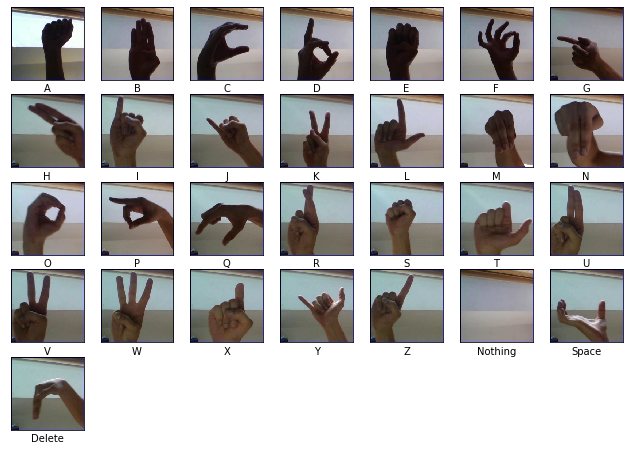

In [0]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'Nothing', 'Space', 'Delete']
plt.figure(figsize=(11, 11))
for i in range (0,29):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    path = "test/{0}.jpg".format(classes[i])
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(classes[i])

### Загружаем данные

In [0]:
def load_data(train_dir):
    images = []
    labels = []
    size = 32,32
    index = -1
    for folder in os.listdir(train_dir):
        index +=1
        for image in os.listdir(train_dir + "/" + folder):
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            images.append(temp_img)
            labels.append(index)
    
    images = np.array(images)
    # Нормализуем данные
    images = images.astype('float32')/255.0
    # Преобразуем метки в one-hot-encoding
    labels = utils.to_categorical(labels)
    # Разделяем данные на тренировочную и тестовую выборки
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1)
    
    print('Loaded', len(x_train),'images for training,','Train data shape =', x_train.shape)
    print('Loaded', len(x_test),'images for testing','Test data shape =', x_test.shape)
    
    return x_train, x_test, y_train, y_test

start = time()
x_train, x_test, y_train, y_test = load_data('train/')
print('Loading:', time() - start)

Loaded 78300 images for training, Train data shape = (78300, 32, 32, 3)
Loaded 8700 images for testing Test data shape = (8700, 32, 32, 3)
Loading: 66.47611403465271


### Запускаем сеть

In [0]:
classes = 29 # Количество классов изображений
batch = 128 # Размер мини-выборки
epochs = 10 # Количество эпох для обучения
learning_rate = 0.001 # Коэффициент скорости обучения

def results(model):
  adam = Adam(lr=learning_rate)

  # Компилируем модель
  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

  # Обучаем модель
  start = time()
  history = model.fit(x_train, y_train, batch_size=batch, epochs=epochs, validation_split=0.1, shuffle = True, verbose=1)
  train_time = time() - start

  # Архитектура сети
  model.summary()

  # Графики изменения метрик
  plt.figure(figsize=(12, 12))
  plt.subplot(3, 2, 1)
  plt.plot(history.history['accuracy'], label = 'train_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.subplot(3, 2, 2)
  plt.plot(history.history['loss'], label = 'train_loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

  # Запускаем на тестовых данных
  start = time()
  test_loss, test_acc = model.evaluate(x_test, y_test)
  test_time = time() - start
  print('\nTrain time: ', train_time)
  print('Test accuracy:', test_acc)
  print('Test loss:', test_loss)
  print('Test time: ', test_time)

#### Конфигурация №1

Train on 70470 samples, validate on 7830 samples
Epoch 1/10
70470/70470 [==============================] - 6s 79us/sample - loss: 2.7495 - accuracy: 0.2172 - val_loss: 2.1571 - val_accuracy: 0.3575
Epoch 2/10
70470/70470 [==============================] - 5s 69us/sample - loss: 1.8767 - accuracy: 0.4267 - val_loss: 1.6125 - val_accuracy: 0.4981
Epoch 3/10
70470/70470 [==============================] - 5s 72us/sample - loss: 1.4722 - accuracy: 0.5378 - val_loss: 1.3106 - val_accuracy: 0.5870
Epoch 4/10
70470/70470 [==============================] - 5s 77us/sample - loss: 1.2187 - accuracy: 0.6191 - val_loss: 1.0931 - val_accuracy: 0.6654
Epoch 5/10
70470/70470 [==============================] - 6s 79us/sample - loss: 1.0471 - accuracy: 0.6693 - val_loss: 0.9506 - val_accuracy: 0.6953
Epoch 6/10
70470/70470 [==============================] - 6s 79us/sample - loss: 0.9176 - accuracy: 0.7076 - val_loss: 0.8948 - val_accuracy: 0.7056
Epoch 7/10
70470/70470 [==============================] -

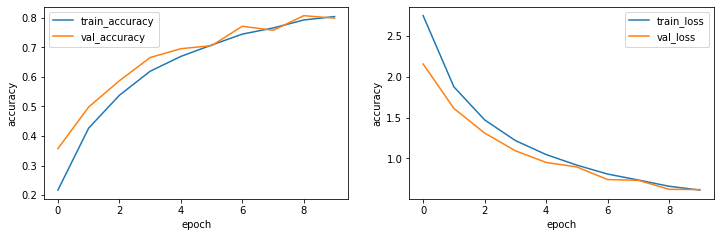

8700/8700 [==============================] - 1s 147us/sample - loss: 0.6510 - accuracy: 0.7848

Train time:  54.6625702381134
Test accuracy: 0.7848276
Test loss: 0.6510051765113042
Test time:  1.317746877670288


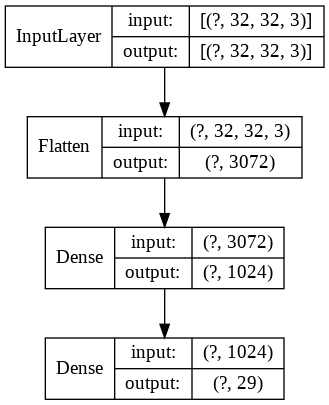

In [0]:
# Создаём модель
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(classes, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)

#### Конфигурация №2

Train on 70470 samples, validate on 7830 samples
Epoch 1/10
70470/70470 [==============================] - 5s 78us/sample - loss: 2.7003 - accuracy: 0.2283 - val_loss: 2.1351 - val_accuracy: 0.3522
Epoch 2/10
70470/70470 [==============================] - 5s 73us/sample - loss: 1.8216 - accuracy: 0.4549 - val_loss: 1.5222 - val_accuracy: 0.5654
Epoch 3/10
70470/70470 [==============================] - 5s 74us/sample - loss: 1.3715 - accuracy: 0.5893 - val_loss: 1.2042 - val_accuracy: 0.6406
Epoch 4/10
70470/70470 [==============================] - 5s 75us/sample - loss: 1.0722 - accuracy: 0.6885 - val_loss: 0.9507 - val_accuracy: 0.7135
Epoch 5/10
70470/70470 [==============================] - 5s 73us/sample - loss: 0.8659 - accuracy: 0.7521 - val_loss: 0.7954 - val_accuracy: 0.7655
Epoch 6/10
70470/70470 [==============================] - 6s 78us/sample - loss: 0.7145 - accuracy: 0.7987 - val_loss: 0.6418 - val_accuracy: 0.8201
Epoch 7/10
70470/70470 [==============================] -

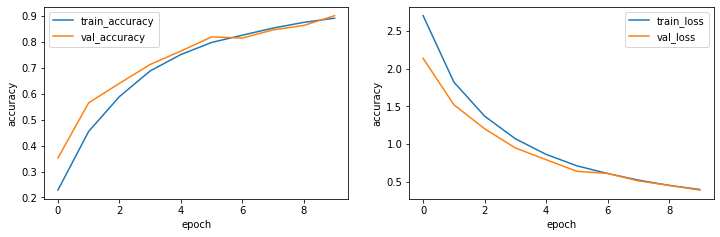

8700/8700 [==============================] - 1s 120us/sample - loss: 0.4070 - accuracy: 0.8931

Train time:  52.69963550567627
Test accuracy: 0.8931034
Test loss: 0.4069546917937268
Test time:  1.0795247554779053


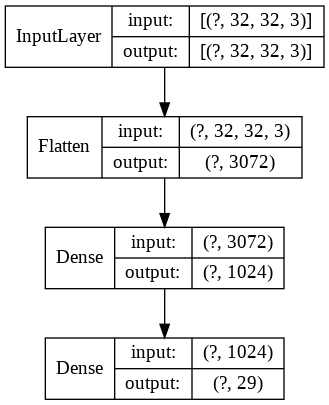

In [0]:
# Создаём модель
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(classes, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)

#### Конфигурация №3

Train on 70470 samples, validate on 7830 samples
Epoch 1/10
70470/70470 [==============================] - 6s 80us/sample - loss: 2.9301 - accuracy: 0.1758 - val_loss: 2.4349 - val_accuracy: 0.2729
Epoch 2/10
70470/70470 [==============================] - 5s 74us/sample - loss: 2.0963 - accuracy: 0.3531 - val_loss: 1.9091 - val_accuracy: 0.3973
Epoch 3/10
70470/70470 [==============================] - 5s 74us/sample - loss: 1.7059 - accuracy: 0.4597 - val_loss: 1.5419 - val_accuracy: 0.4996
Epoch 4/10
70470/70470 [==============================] - 5s 75us/sample - loss: 1.4641 - accuracy: 0.5313 - val_loss: 1.3315 - val_accuracy: 0.5682
Epoch 5/10
70470/70470 [==============================] - 5s 74us/sample - loss: 1.2610 - accuracy: 0.5959 - val_loss: 1.1580 - val_accuracy: 0.6404
Epoch 6/10
70470/70470 [==============================] - 5s 74us/sample - loss: 1.1295 - accuracy: 0.6386 - val_loss: 1.0219 - val_accuracy: 0.6797
Epoch 7/10
70470/70470 [==============================] -

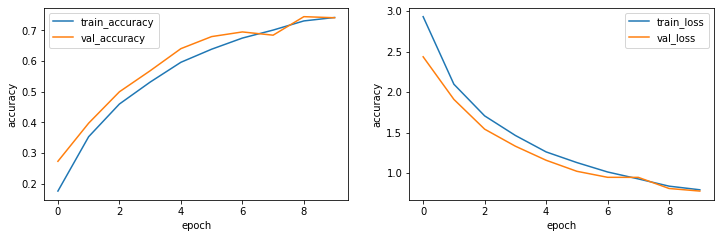

8700/8700 [==============================] - 1s 123us/sample - loss: 0.8076 - accuracy: 0.7295

Train time:  52.748558044433594
Test accuracy: 0.7295402
Test loss: 0.8076016546391893
Test time:  1.1104474067687988


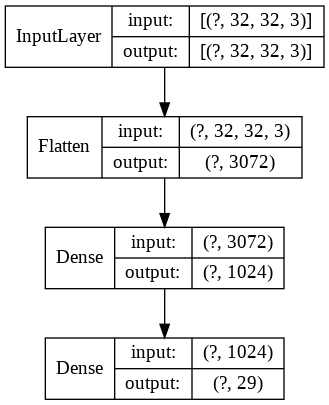

In [0]:
# Создаём модель
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dense(1024, activation='tanh'))
model.add(Dense(classes, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)

#### Конфигурация №4

Train on 70470 samples, validate on 7830 samples
Epoch 1/10
70470/70470 [==============================] - 6s 85us/sample - loss: 2.4227 - accuracy: 0.2763 - val_loss: 1.6311 - val_accuracy: 0.4608
Epoch 2/10
70470/70470 [==============================] - 5s 77us/sample - loss: 1.2627 - accuracy: 0.5775 - val_loss: 0.9824 - val_accuracy: 0.6602
Epoch 3/10
70470/70470 [==============================] - 5s 75us/sample - loss: 0.8429 - accuracy: 0.7080 - val_loss: 0.7035 - val_accuracy: 0.7582
Epoch 4/10
70470/70470 [==============================] - 5s 72us/sample - loss: 0.6200 - accuracy: 0.7813 - val_loss: 0.5182 - val_accuracy: 0.8124
Epoch 5/10
70470/70470 [==============================] - 6s 86us/sample - loss: 0.4895 - accuracy: 0.8271 - val_loss: 0.5388 - val_accuracy: 0.8017
Epoch 6/10
70470/70470 [==============================] - 6s 83us/sample - loss: 0.3933 - accuracy: 0.8610 - val_loss: 0.3066 - val_accuracy: 0.8939
Epoch 7/10
70470/70470 [==============================] -

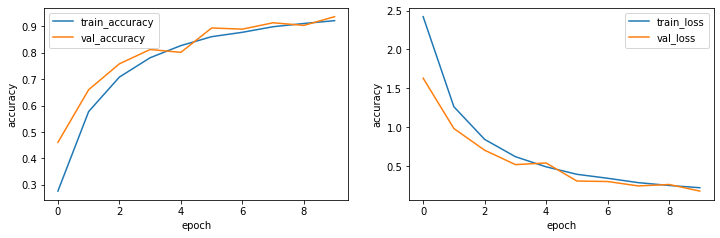

8700/8700 [==============================] - 1s 133us/sample - loss: 0.1969 - accuracy: 0.9303

Train time:  58.515350580215454
Test accuracy: 0.9303448
Test loss: 0.19685974935348005
Test time:  1.1966428756713867


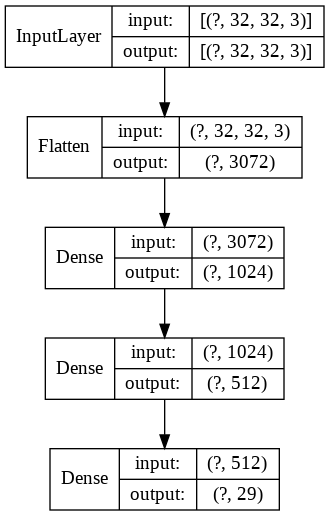

In [0]:
# Создаём модель
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(classes, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)

#### Конфигурация №5

Train on 70470 samples, validate on 7830 samples
Epoch 1/10
70470/70470 [==============================] - 6s 90us/sample - loss: 2.4867 - accuracy: 0.2495 - val_loss: 1.8630 - val_accuracy: 0.4095
Epoch 2/10
70470/70470 [==============================] - 6s 90us/sample - loss: 1.4682 - accuracy: 0.5227 - val_loss: 1.4154 - val_accuracy: 0.5340
Epoch 3/10
70470/70470 [==============================] - 6s 86us/sample - loss: 1.0261 - accuracy: 0.6623 - val_loss: 0.9571 - val_accuracy: 0.6770
Epoch 4/10
70470/70470 [==============================] - 6s 88us/sample - loss: 0.7718 - accuracy: 0.7448 - val_loss: 0.6386 - val_accuracy: 0.7885
Epoch 5/10
70470/70470 [==============================] - 6s 86us/sample - loss: 0.6004 - accuracy: 0.8028 - val_loss: 0.5348 - val_accuracy: 0.8218
Epoch 6/10
70470/70470 [==============================] - 6s 82us/sample - loss: 0.4997 - accuracy: 0.8352 - val_loss: 0.4102 - val_accuracy: 0.8774
Epoch 7/10
70470/70470 [==============================] -

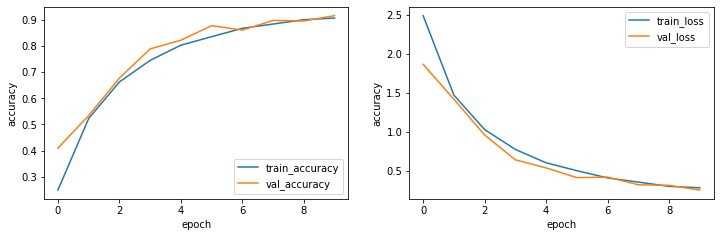

8700/8700 [==============================] - 1s 147us/sample - loss: 0.2538 - accuracy: 0.9167

Train time:  61.34454965591431
Test accuracy: 0.9166667
Test loss: 0.2538202193756213
Test time:  1.312868595123291


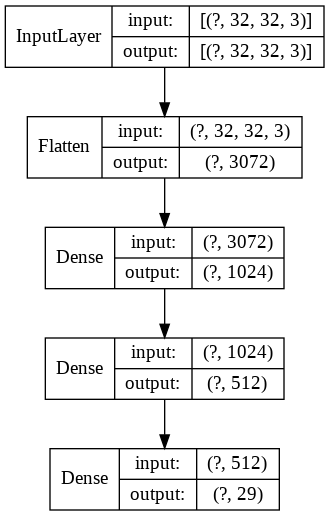

In [0]:
# Создаём модель
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(classes, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)

#### Конфигурация №6

Train on 70470 samples, validate on 7830 samples
Epoch 1/10
70470/70470 [==============================] - 6s 88us/sample - loss: 3.1599 - accuracy: 0.0933 - val_loss: 2.6796 - val_accuracy: 0.1870
Epoch 2/10
70470/70470 [==============================] - 5s 78us/sample - loss: 2.4471 - accuracy: 0.2157 - val_loss: 2.1729 - val_accuracy: 0.2797
Epoch 3/10
70470/70470 [==============================] - 5s 78us/sample - loss: 2.0241 - accuracy: 0.3137 - val_loss: 1.8665 - val_accuracy: 0.3415
Epoch 4/10
70470/70470 [==============================] - 5s 76us/sample - loss: 1.8040 - accuracy: 0.3715 - val_loss: 1.6551 - val_accuracy: 0.4157
Epoch 5/10
70470/70470 [==============================] - 5s 75us/sample - loss: 1.6289 - accuracy: 0.4213 - val_loss: 1.5447 - val_accuracy: 0.4387
Epoch 6/10
70470/70470 [==============================] - 5s 75us/sample - loss: 1.5218 - accuracy: 0.4561 - val_loss: 1.4716 - val_accuracy: 0.4812
Epoch 7/10
70470/70470 [==============================] -

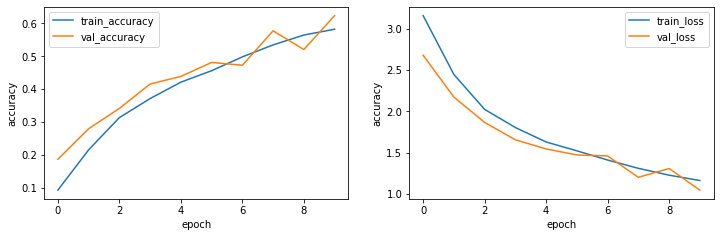

8700/8700 [==============================] - 1s 144us/sample - loss: 1.0663 - accuracy: 0.6100

Train time:  55.40600609779358
Test accuracy: 0.61
Test loss: 1.0663014990707924
Test time:  1.2946350574493408


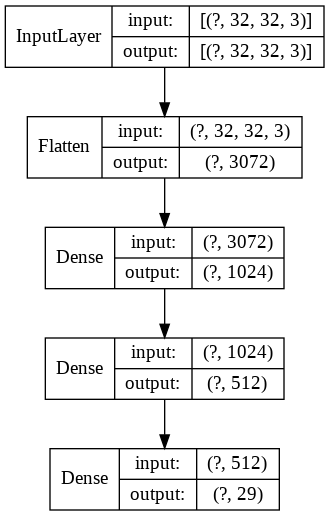

In [0]:
# Создаём модель
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dense(1024, activation='tanh'))
model.add(Dense(512, activation='tanh'))
model.add(Dense(classes, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)

####  Конфигурация №7

Train on 70470 samples, validate on 7830 samples
Epoch 1/10
70470/70470 [==============================] - 8s 111us/sample - loss: 2.3649 - accuracy: 0.2796 - val_loss: 1.6484 - val_accuracy: 0.4441
Epoch 2/10
70470/70470 [==============================] - 8s 109us/sample - loss: 1.1748 - accuracy: 0.5941 - val_loss: 0.8950 - val_accuracy: 0.6802
Epoch 3/10
70470/70470 [==============================] - 7s 104us/sample - loss: 0.7784 - accuracy: 0.7232 - val_loss: 0.6264 - val_accuracy: 0.7714
Epoch 4/10
70470/70470 [==============================] - 7s 106us/sample - loss: 0.5585 - accuracy: 0.7981 - val_loss: 0.5169 - val_accuracy: 0.8092
Epoch 5/10
70470/70470 [==============================] - 8s 108us/sample - loss: 0.4451 - accuracy: 0.8363 - val_loss: 0.3512 - val_accuracy: 0.8681
Epoch 6/10
70470/70470 [==============================] - 8s 114us/sample - loss: 0.3648 - accuracy: 0.8673 - val_loss: 0.3550 - val_accuracy: 0.8676
Epoch 7/10
70470/70470 [===========================

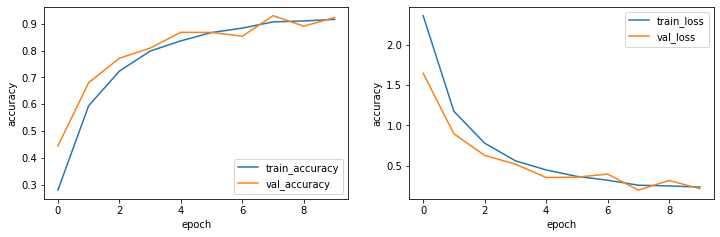

8700/8700 [==============================] - 1s 149us/sample - loss: 0.2224 - accuracy: 0.9184

Train time:  73.53259348869324
Test accuracy: 0.9183908
Test loss: 0.2223928897579511
Test time:  1.7257256507873535


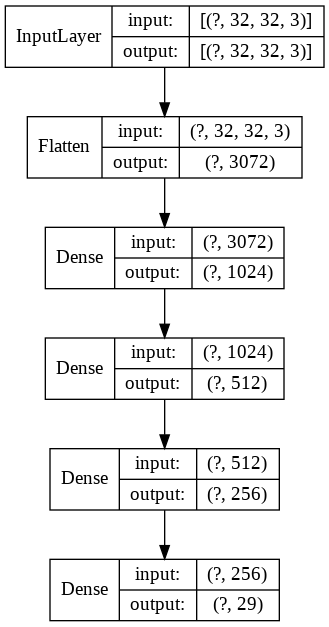

In [0]:
# Создаём модель
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(classes, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)

####  Конфигурация №8

Train on 70470 samples, validate on 7830 samples
Epoch 1/10
70470/70470 [==============================] - 7s 94us/sample - loss: 2.6175 - accuracy: 0.1949 - val_loss: 1.8422 - val_accuracy: 0.4055
Epoch 2/10
70470/70470 [==============================] - 6s 90us/sample - loss: 1.6142 - accuracy: 0.4431 - val_loss: 1.3022 - val_accuracy: 0.5577
Epoch 3/10
70470/70470 [==============================] - 6s 92us/sample - loss: 1.2196 - accuracy: 0.5767 - val_loss: 1.0630 - val_accuracy: 0.6327
Epoch 4/10
70470/70470 [==============================] - 6s 91us/sample - loss: 0.9535 - accuracy: 0.6685 - val_loss: 0.8182 - val_accuracy: 0.7166
Epoch 5/10
70470/70470 [==============================] - 6s 90us/sample - loss: 0.7637 - accuracy: 0.7341 - val_loss: 1.1462 - val_accuracy: 0.5888
Epoch 6/10
70470/70470 [==============================] - 6s 90us/sample - loss: 0.6491 - accuracy: 0.7703 - val_loss: 0.5946 - val_accuracy: 0.7866
Epoch 7/10
70470/70470 [==============================] -

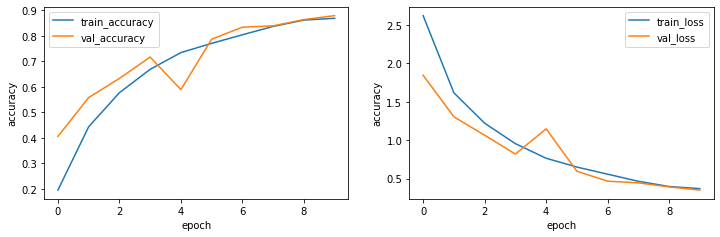

8700/8700 [==============================] - 1s 135us/sample - loss: 0.3699 - accuracy: 0.8679

Train time:  63.449477434158325
Test accuracy: 0.867931
Test loss: 0.3698697227445142
Test time:  1.2199876308441162


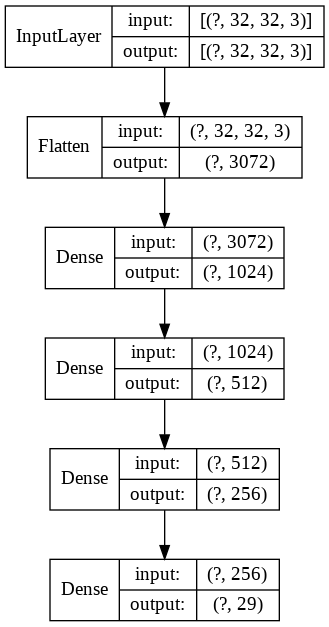

In [0]:
# Создаём модель
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(classes, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)

####  Конфигурация №9

Train on 70470 samples, validate on 7830 samples
Epoch 1/10
70470/70470 [==============================] - 7s 93us/sample - loss: 3.0627 - accuracy: 0.0885 - val_loss: 2.7173 - val_accuracy: 0.1406
Epoch 2/10
70470/70470 [==============================] - 6s 84us/sample - loss: 2.4846 - accuracy: 0.1855 - val_loss: 2.3942 - val_accuracy: 0.2022
Epoch 3/10
70470/70470 [==============================] - 6s 85us/sample - loss: 2.1080 - accuracy: 0.2763 - val_loss: 2.1281 - val_accuracy: 0.2572
Epoch 4/10
70470/70470 [==============================] - 6s 85us/sample - loss: 1.9000 - accuracy: 0.3317 - val_loss: 1.8187 - val_accuracy: 0.3567
Epoch 5/10
70470/70470 [==============================] - 6s 86us/sample - loss: 1.7348 - accuracy: 0.3825 - val_loss: 1.5691 - val_accuracy: 0.4451
Epoch 6/10
70470/70470 [==============================] - 6s 85us/sample - loss: 1.6255 - accuracy: 0.4168 - val_loss: 1.5641 - val_accuracy: 0.4243
Epoch 7/10
70470/70470 [==============================] -

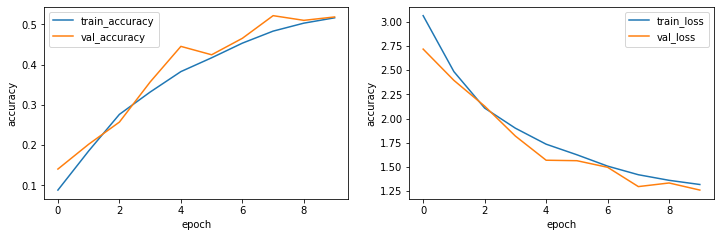

8700/8700 [==============================] - 1s 148us/sample - loss: 1.2918 - accuracy: 0.5046

Train time:  60.643210887908936
Test accuracy: 0.5045977
Test loss: 1.2918288907785525
Test time:  1.346670389175415


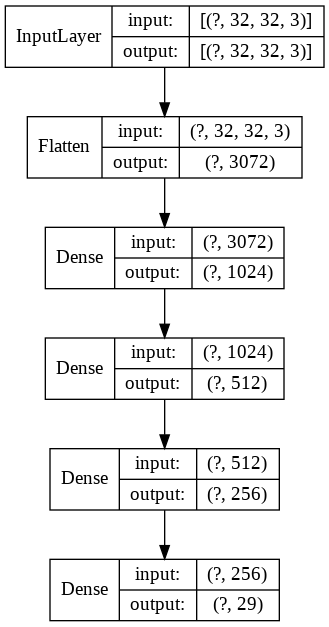

In [0]:
# Создаём модель
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dense(1024, activation='tanh'))
model.add(Dense(512, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(classes, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)